In [1]:
import json
from pycocotools.coco import COCO

import numpy as np
import pandas as pd

from tqdm import tqdm
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import cv2
import webcolors

In [2]:
with open('/opt/ml/input/data/new_train_all_anno_excluded.json', 'r', encoding='UTF-8') as train_json:
    train_data = json.load(train_json)

    tr_images = train_data['images']
    tr_annotations = train_data['annotations']
    tr_categories = train_data['categories']

In [3]:
for img in tr_images:
    if img['file_name'] == 'batch_02_vt/1059.jpg':
        print(img['id'])

1770


In [4]:
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

In [5]:
coco = COCO('/opt/ml/input/data/new_train_all_anno_excluded.json')

loading annotations into memory...
Done (t=5.14s)
creating index...
index created!


### Noise Data

In [21]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

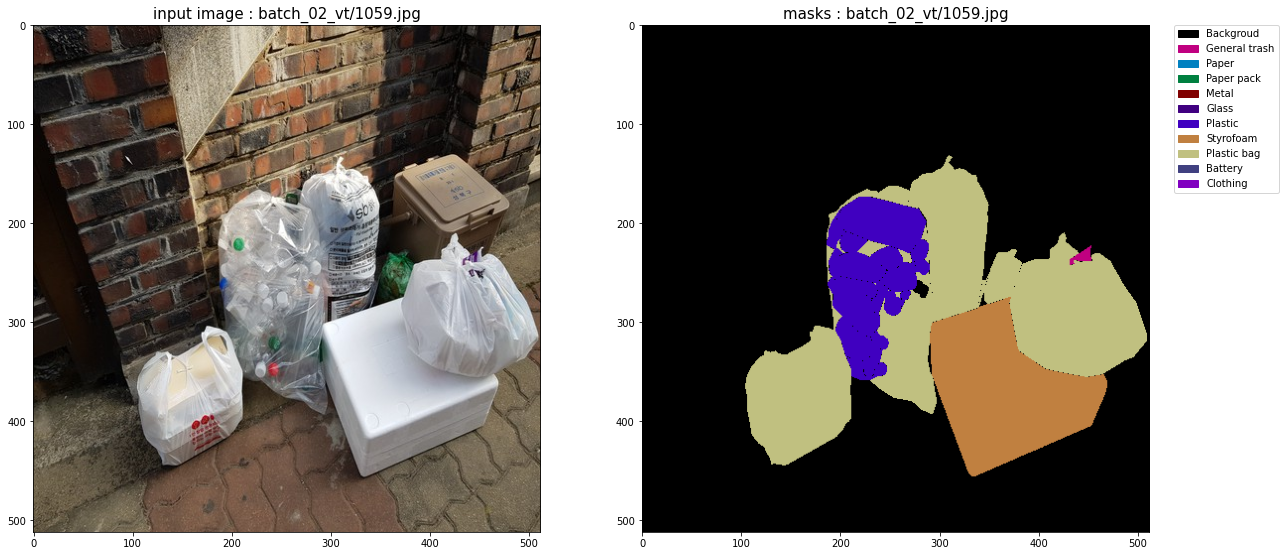

In [24]:
category_names = [
    "Background",
    "General trash",
    "Paper",
    "Paper pack",
    "Metal",
    "Glass",
    "Plastic",
    "Styrofoam",
    "Plastic bag",
    "Battery",
    "Clothing",
]

dataset_path = '/opt/ml/input/data'

# variable for legend
class_colormap = pd.read_csv("/opt/ml/input/code/class_dict.csv")

category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                        edgecolor=webcolors.rgb_to_hex(rgb), 
                        label=category) for category, rgb in category_and_rgb]

image_infos = coco.loadImgs(1770)[0]

ann_ids = coco.getAnnIds(imgIds=1770)
anns = coco.loadAnns(ann_ids)

cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)

masks = np.zeros((512, 512))

anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)

for i in range(len(anns)):
    className = get_classname(anns[i]['category_id'], cats)
    pixel_value = category_names.index(className)
    masks[coco.annToMask(anns[i]) == 1] = pixel_value
masks = masks.astype(np.int8)
masks = label_to_color_image(masks)

images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))

ax1.imshow(images)
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(masks)
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

ax2.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [7]:
tr_categories

[{'id': 1, 'name': 'General trash', 'supercategory': 'General trash'},
 {'id': 2, 'name': 'Paper', 'supercategory': 'Paper'},
 {'id': 3, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
 {'id': 4, 'name': 'Metal', 'supercategory': 'Metal'},
 {'id': 5, 'name': 'Glass', 'supercategory': 'Glass'},
 {'id': 6, 'name': 'Plastic', 'supercategory': 'Plastic'},
 {'id': 7, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
 {'id': 8, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
 {'id': 9, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 10, 'name': 'Clothing', 'supercategory': 'Clothing'}]

In [8]:
# segmentation 좌표가 겹치는 곳이 있는지 확인하는 코드. 결과 0개
'''
noise_imgs_id = set()

for i in tqdm(range(len(tr_annotations))):
    img_id = tr_annotations[i]['image_id']

    seg1 = tr_annotations[i]['segmentation']

    for j in range(len(tr_annotations)):
        if j != i and tr_annotations[j]['image_id'] == img_id:
            seg2 = tr_annotations[j]['segmentation']

            for seg_i in range(0, len(seg1), 2):
                for seg_j in range(0, len(seg2), 2):
                    if seg1[seg_i] == seg2[seg_j] and seg1[seg_i+1] == seg2[seg_j+1]:
                        for img in tr_images:
                            noise_imgs_id.add(img['id'])
                            print(img['file_name'])
len(noise_imgs_id)
'''

"\nnoise_imgs_id = set()\n\nfor i in tqdm(range(len(tr_annotations))):\n    img_id = tr_annotations[i]['image_id']\n\n    seg1 = tr_annotations[i]['segmentation']\n\n    for j in range(len(tr_annotations)):\n        if j != i and tr_annotations[j]['image_id'] == img_id:\n            seg2 = tr_annotations[j]['segmentation']\n\n            for seg_i in range(0, len(seg1), 2):\n                for seg_j in range(0, len(seg2), 2):\n                    if seg1[seg_i] == seg2[seg_j] and seg1[seg_i+1] == seg2[seg_j+1]:\n                        for img in tr_images:\n                            noise_imgs_id.add(img['id'])\n                            print(img['file_name'])\nlen(noise_imgs_id)\n"

In [9]:
# plastic bag의 bbox 안에 다른 객체가 있다면 추가.
noise_imgs_id = set()

for i in tqdm(range(len(tr_annotations))):
    if tr_annotations[i]['category_id'] == 8:
        img_id = tr_annotations[i]['image_id']

        bbox_pb = tr_annotations[i]['bbox']

        x_min_pb = bbox_pb[0]
        y_min_pb = bbox_pb[1]
        x_max_pb = x_min_pb + bbox_pb[2]
        y_max_pb = y_min_pb + bbox_pb[3]

        for j in range(len(tr_annotations)):
            if j != i and tr_annotations[j]['image_id'] == img_id:
                bbox = tr_annotations[j]['bbox']

                x_min = bbox[0]
                y_min = bbox[1]
                x_max = x_min + bbox[2]
                y_max = y_min + bbox[3]

                if x_min_pb <= x_min and y_min_pb <= y_min and x_max_pb >= x_max and y_max_pb >= y_max:
                    for img in tr_images:
                        if img['id'] == img_id:
                            noise_imgs_id.add(img['id'])

len(noise_imgs_id)


100%|██████████| 26936/26936 [01:11<00:00, 376.48it/s]


1035

In [10]:
noise_imgs_id = list(noise_imgs_id)
noise_imgs_id.sort()

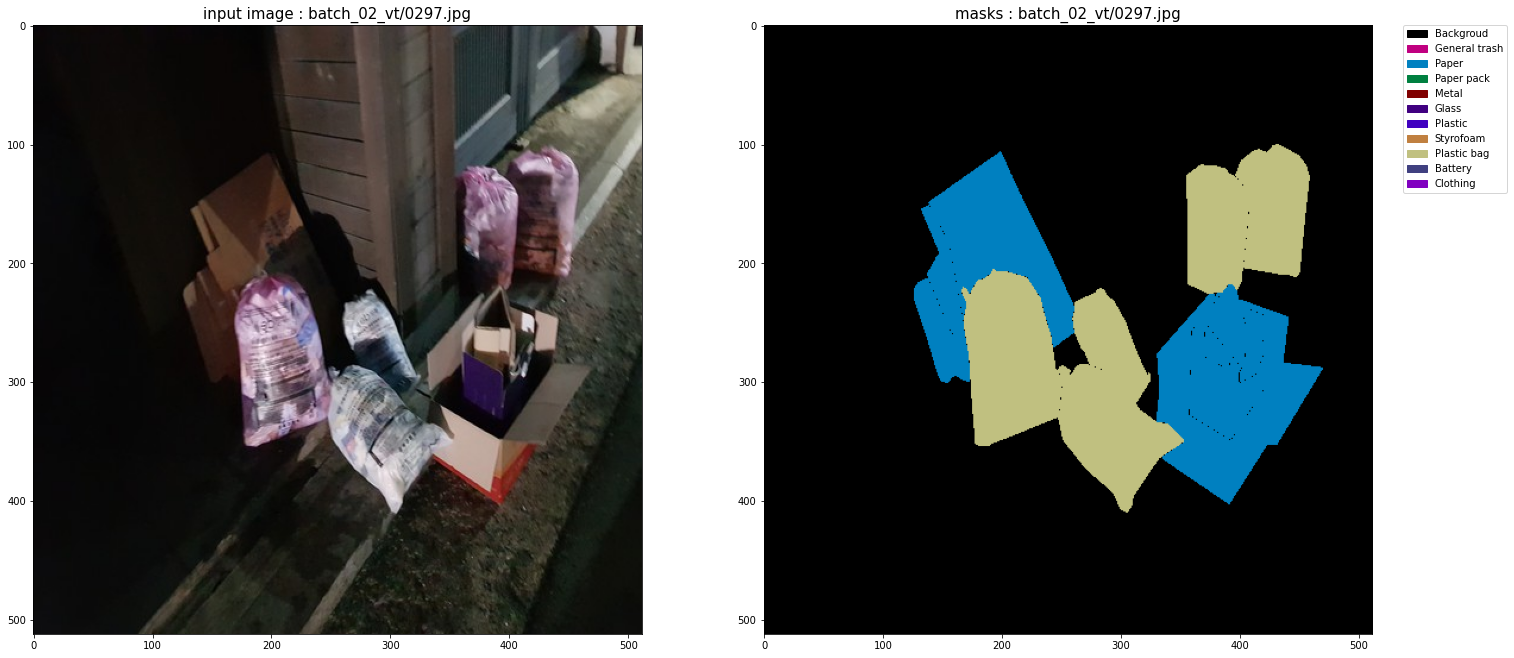

In [25]:
'''
각자 검수할 index

김규민: 0~199
박정재: 200~399
서경국: 400~599
이융희: 600~799
전다운: 800~1034
'''

index = 250

for i in range(index, index+1):

    image_infos = coco.loadImgs(noise_imgs_id[i])[0]

    ann_ids = coco.getAnnIds(imgIds=noise_imgs_id[i])
    anns = coco.loadAnns(ann_ids)

    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)

    masks = np.zeros((512, 512))

    anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)

    for j in range(len(anns)):
        className = get_classname(anns[j]['category_id'], cats)
        pixel_value = category_names.index(className)
        masks[coco.annToMask(anns[j]) == 1] = pixel_value
    masks = masks.astype(np.int8)
    masks = label_to_color_image(masks)

    images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
    images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 24))

    ax1.imshow(images)
    ax1.grid(False)
    ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

    ax2.imshow(masks)
    ax2.grid(False)
    ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    